#### Creates metadata file of images used for model training from the parsed and filtered dataset.

In [1]:
# auto reload modules
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from utils.helpers import get_areds_data_dir
from utils.create_survival_data import get_survival_data
from pathlib import Path

In [4]:
# Parsed and filtered metadata file from AREDS, relative to the data root as specified in configs/dirs.yml
FILTERED_METADATA_CSV = "data_processed/metadata/image_level_metadata_filtered.csv"

visit_numbers = None
remove_odd_visits = False
event_grade = 9 # This is the zero-based AREDS severity score, i.e. 9 and above is late AMD
keep_metadata = True
data_root = Path(get_areds_data_dir(scratch=True))
metadata_csv = data_root.joinpath(FILTERED_METADATA_CSV)

In [5]:
print("length of parsed and filtered data: ", len(pd.read_csv(metadata_csv)))

length of parsed and filtered data:  133293


Decide on metadata file to create (i.e., normal (one view per eye) or with stereo pairs) <br>
Uncomment the appropriate code block and run the notebook.

In [6]:
# Standard metadata. For all except the stereo pair model (Babenko et al.)
filename = "metadata_surv.csv"
keep_stereo_pairs = False
delete_initial_converters = False
shift_odd_visits = False
keep_converted = False

# # Stereo pair version for Babenko et al.
# filename = "metadata_surv_stereo.csv"
# keep_stereo_pairs = True
# delete_initial_converters = False
# shift_odd_visits = False
# keep_converted = False

In [1]:
drop_after_event = False if "keep_converted" in locals() and keep_converted else True

df_surv = get_survival_data(
        metadata_csv.__str__(),
        event_grade=event_grade,
        remove_odd_visits=remove_odd_visits,
        visit_numbers=visit_numbers,
        impute=True if keep_metadata else False,
        absolute_durations=False,
        drop_after_event=drop_after_event,
        keep_stereo_pairs=keep_stereo_pairs,
    )

if not drop_after_event: # keeping converted
    df_surv.loc[df_surv["duration"] < 0, "duration"] = 0

if delete_initial_converters:
    df_surv = df_surv[
        ~((df_surv["event"] == 1) & (df_surv["duration"] == 0))
    ]

if shift_odd_visits:
    # add 1 to all odd durations -> Converted in the time until the next even visit
    df_surv.loc[df_surv["duration"] % 2 == 1, "duration"] += 1

In [8]:
df_surv[["patient_id", "event", "duration"]].head()

,patient_id,event,duration
0,1001_left_RS,False,16
1,1001_right_LS,False,16
2,1001_left_LS,False,14
3,1001_right_LS,False,14
4,1001_left_RS,False,12


In [9]:
len(df_surv)

52544

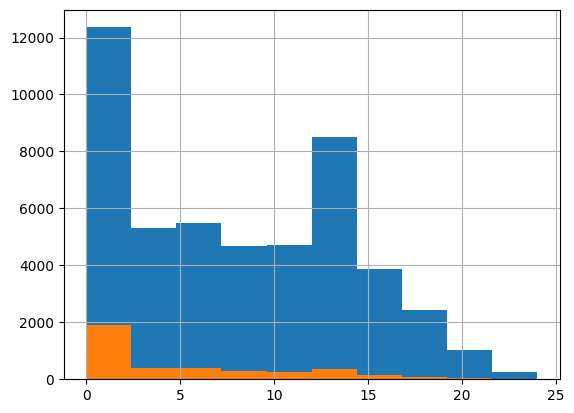

In [10]:
# Plot the distribution of the duration by converter status
for event in df_surv["event"].unique():
    df_surv[df_surv["event"] == event]["duration"].hist()

In [11]:
df_surv["event"].value_counts()

False    48636
True      3908
Name: event, dtype: int64

In [12]:
# Shuffle the data but alternate between converters and non-converters. Good for testing runs with subset of data
df_surv_converters = df_surv[df_surv["event"] == True].sample(frac=1, random_state=42).reset_index(drop=True)
df_surv_converters.index = np.arange(1, len(df_surv_converters)*2, 2)

df_surv_non_converters = df_surv[df_surv["event"] == False].sample(frac=1, random_state=42).reset_index(drop=True)
df_surv_non_converters.index = np.arange(0, len(df_surv_non_converters)*2, 2)

df_surv = pd.concat([df_surv_converters, df_surv_non_converters]).sort_index()

Save dataset

In [13]:
df_surv.to_csv(f'data/{filename}')

#### (Optional) Load and check if IPCW can be computed: <br>Estimation of censoring distribution, needed as weight for censoring adjusted metrics from sksurv

In [14]:
from data.cnn_surv_dataloader import get_dataset
from utils.helpers import get_config
from utils.cnn_survival_utils import check_ipcw_calc
import pandas as pd

In [15]:
df_surv = pd.read_csv(f'data/{filename}')

In [16]:
c = get_config("sparsebagnet_cox.yml")
c.metadata_csv = f'data/{filename}'
c.cnn.gpu = 0
c.cnn.test_run["enabled"] = False
c.cnn.train_set_fraction = 1.0
c.cnn.val_set_fraction = 1.0

In [17]:
y_train_set = get_dataset(split="train", c=c)
y_val_set = get_dataset(split="val", c=c)
y_test_set = get_dataset(split="test", c=c)

y_survival = {
    "train": y_train_set.get_e_t(),
    "val": y_val_set.get_e_t(),
    "test": y_test_set.get_e_t(),
}

Len data (Number of images in train split): 31459
Len data (Number of images in val split): 10496
Len data (Number of images in test split): 10589


In [19]:
df_y_train = pd.DataFrame(y_train_set._e.numpy(), columns=["event"])
df_y_train["duration"] = y_train_set._t.numpy()
df_y_val = pd.DataFrame(y_val_set._e.numpy(), columns=["event"])
df_y_val["duration"] = y_val_set._t.numpy()
df_y_test = pd.DataFrame(y_test_set._e.numpy(), columns=["event"])
df_y_test["duration"] = y_test_set._t.numpy()


In [24]:
assert check_ipcw_calc(y_survival["train"], y_survival["val"]), "Error, IPCW calculation failed"

max time train 24.0
